# Torch Hub YOLOv5 and SSD — Models on Object Detection

Source: [pyimagesearch: Torch Hub Series #3: YOLOv5 and SSD — Models on Object Detection](https://www.pyimagesearch.com/2022/01/03/torch-hub-series-3-yolov5-and-ssd-models-on-object-detection/)

In [1]:
! pip install opencv-contrib-python

## Download kaggle Dogs & Cats images

In [2]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"frankmerwerth","key":"46cfa0176969d222904a078cb6e5f8b3"}'}

In [3]:
! mkdir ~/.kaggle
! mv ./kaggle.json ~/.kaggle/
# grant full access to read and write json file
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sixhky/open-images-bus-trucks
! unzip -qq open-images-bus-trucks.zip
! rm open-images-bus-trucks.zip

 99% 364M/367M [00:03<00:00, 147MB/s]
100% 367M/367M [00:03<00:00, 111MB/s]


## Configuration

In [4]:
# import the necessary packages
import torch
import os

# define the root directory followed by the test dataset paths
BASE_PATH = "dataset"
TEST_PATH = os.path.join(BASE_PATH, "test_set")

BASE_PATH = "images"
TEST_PATH = os.path.join(BASE_PATH, "images")

# specify image size and batch size
IMAGE_SIZE = 300
PRED_BATCH_SIZE = 4

# specify threshold confidence value for ssd detections
THRESHOLD = 0.50

# determine the device type 
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# define paths to save output 
OUTPUT_PATH = "output"
SSD_OUTPUT = os.path.join(OUTPUT_PATH, "ssd_output")
YOLO_OUTPUT = os.path.join(OUTPUT_PATH, "yolo_output")

In [5]:
import pandas as pd
import shutil
from tqdm import tqdm

# for the ImageFolder function to work (see later), the images must be arranged 
# in subfolders that represent the class names 

image_list = os.listdir(TEST_PATH)
df = pd.read_csv('df.csv')

for image in tqdm(image_list):
  imageID = image.split('.')[0]
  label = df[df['ImageID'] == imageID].LabelName.iloc[0]

  if not os.path.exists(os.path.join(BASE_PATH, label)):
    os.makedirs(os.path.join(BASE_PATH, label))

  shutil.move(os.path.join(BASE_PATH, 'images', image), os.path.join(BASE_PATH, label, image))

os.rmdir(os.path.join(BASE_PATH, 'images'))

100%|██████████| 15225/15225 [00:29<00:00, 517.52it/s]


## Helper Function for Dataloader

In [6]:
# import the necessary packages
from torch.utils.data import DataLoader

def get_dataloader(dataset, batchSize, shuffle=True):
	# create a PyTorch Dataloader and return it. 
  # The Dataloader instance solves a lot of hassle, which goes into writing separate custom generator classes for huge datasets.
	dataLoader= DataLoader(dataset, batch_size=batchSize,
		shuffle=shuffle)
	return dataLoader

In [7]:
def normalize(image, mean=128, std=128):
    # normalize the SSD input and return it 
    image = (image * 256 - mean) / std
    return image

## Yolov5 inference

[YOLO, or "You Only Look Once” (2015)](https://arxiv.org/abs/1506.02640) , introduced an ingenious way to tackle the objext detection challenge. It splits each image into an S×S grid, getting object positions corresponding to each cell. Of course, some cells won’t have any objects, while others will appear in multiple cells.

Each cell will then output a probability value (probability of an object being in the cell), the detected object class, and the bounding box values unique to the cell.

YOLOv5 implements several improvements compared to he first YOLO concept:

*   the concept of anchor boxes (already introduced in YOLOv2): A series of predetermined bounding boxes, anchor boxes are of specific dimensions. These boxes are chosen depending on object sizes in your training datasets to capture the scale and aspect ratio of various object classes you want to detect. The network predicts the probabilities corresponding to the anchor boxes rather than the bounding boxes themselves.
*   YOLOv5 introduces auto-learning anchor boxes to avoid problems in case custom dataset does not have the same anchor box definitions as the training dataset (e.g. COCO) . It also utilizes mosaic augmentation, mixing random images to make your model adept at identifying objects at a smaller scale.

In [8]:
# import necessary packages
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import cv2

# initialize test transform pipeline
testTransform = Compose([
	Resize((IMAGE_SIZE, IMAGE_SIZE)), ToTensor()])
# create the test dataset
testDataset = ImageFolder(BASE_PATH, testTransform)
# initialize the test data loader
testLoader = get_dataloader(testDataset, PRED_BATCH_SIZE)

## Create Yolov5 instance

In [9]:
# initialize the yolov5 using torch hub
yoloModel = torch.hub.load("ultralytics/yolov5", "yolov5s")

# initialize iterable variable to later on grab effeciently random batches of images from a dataset.
sweeper = iter(testLoader)

# initialize image 
imageInput = []

# grab a batch of test data
print("[INFO] getting the test data...")
batch = next(sweeper)
(images, _) = (batch[0], batch[1])

# send the images to the device
images = images.to(DEVICE) 

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-1-27 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)



  0%|          | 0.00/14.0M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


[INFO] getting the test data...


In [10]:
# loop over all the batch 
for index in range(0, PRED_BATCH_SIZE):
	# grab each image
	# rearrange dimensions to channel last and
	# append them to image list
	image = images[index]
	image = image.permute((1, 2, 0))
	imageInput.append(image.cpu().detach().numpy()*255.0)
 
# pass the image list through the model
print("[INFO] getting detections from the test data...")
results = yoloModel(imageInput, size=300)

[INFO] getting detections from the test data...


[INFO] saving the inference...


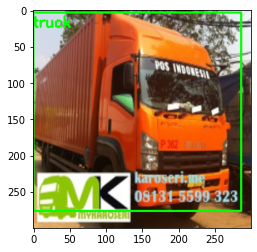

In [11]:
# get random index value
randomIndex = random.randint(0,len(imageInput)-1)

# grab index result from results variable
imageIndex= results.pandas().xyxy[randomIndex]

# convert the bounding box values to integer
startX = int(imageIndex["xmin"][0])
startY = int(imageIndex["ymin"][0])
endX = int(imageIndex["xmax"][0])
endY = int(imageIndex["ymax"][0])

# draw the predicted bounding box and class label on the image
y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(imageInput[randomIndex], imageIndex["name"][0],
	(startX, y+10), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(imageInput[randomIndex],
	(startX, startY), (endX, endY),(0, 255, 0), 2)

# check to see if the output directory already exists, if not
# make the output directory
if not os.path.exists(YOLO_OUTPUT):
    os.makedirs(YOLO_OUTPUT)

# show the output image and save it to path
%matplotlib inline
plt.imshow(imageInput[randomIndex]/255.0)

# save plots to output directory
print("[INFO] saving the inference...")
outputFileName = os.path.join(YOLO_OUTPUT, "output.png")
plt.savefig(outputFileName)

## SSD
The second approach is the [SSD or Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) model for object detection. The SSD300 originally used a VGG backbone for adept feature detection and utilized Szegedy‘s work on MultiBox, a method for quick class-agnostic bounding box coordinate recommendations, inspired SSD’s bounding box regression algorithm. 

Inspired by inception-net, the Multibox architecture created by Szegedy utilizes a multiscale convolutional architecture. Multibox uses a series of normal convolutional and 1×1 filters (changing channel size but keeping height and width intact) to incorporate a multiscale bounding box and confidence prediction model.

The SSD was famous for utilizing multiscale feature maps instead of single feature maps for detections. This allowed for finer detections and more granularity in the predictions. Using these feature maps, the anchor boxes for object predictions were generated.

It had outperformed its compatriots when it came out, especially in speed. Today we’ll be using Torch Hub’s showcased SSD, which uses a ResNet instead of a VGG net as its backbone. Also, some other changes, like removing some layers according to the Speed/accuracy trade-offs for modern convolutional object detectors paper, were applied to the model.

In [12]:
# import the necessary packages
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import cv2

# initialize test transform pipeline
testTransform = Compose([
	Resize((IMAGE_SIZE, IMAGE_SIZE)), ToTensor()])

# create the test dataset and initialize the test data loader
testDataset = ImageFolder(BASE_PATH, testTransform)
testLoader = get_dataloader(testDataset, PRED_BATCH_SIZE)

# initialize iterable variable
sweeper = iter(testLoader)

# list to store permuted images
imageInput = []

In [13]:
# grab a batch of test data
print("[INFO] getting the test data...")
batch = next(sweeper)
(images, _ ) = (batch[0], batch[1])

# switch off autograd
with torch.no_grad():
	# send the images to the device
	images = images.to(DEVICE) 
 
	# loop over all the batch 
	for index in range(0, PRED_BATCH_SIZE):
		# grab the image, de-normalize it, scale the raw pixel
		# intensities to the range [0, 255], and change the channel
		# ordering from channels first tp channels last
		image = images[index]
		image = image.permute((1, 2, 0))
		imageInput.append(image.cpu().detach().numpy())

[INFO] getting the test data...


In [14]:
# call the required entry points
ssdModel = torch.hub.load("NVIDIA/DeepLearningExamples:torchhub",
	"nvidia_ssd")
utils = torch.hub.load("NVIDIA/DeepLearningExamples:torchhub", 
	"nvidia_ssd_processing_utils")

# flash model to the device and set it to eval mode
ssdModel.to(DEVICE)
ssdModel.eval()

# new list for processed input
processedInput = []

# loop over images and preprocess them
for image in imageInput:
	image = normalize (image)
	processedInput.append(image)
 
# convert the preprocessed images into tensors
inputTensor = utils.prepare_tensor(processedInput)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [15]:
# turn off auto-grad
print("[INFO] getting detections from the test data...")
with torch.no_grad():
	# feed images to model
	detections = ssdModel(inputTensor)
 
# decode the results and filter them using the threshold
resultsPerInput = utils.decode_results(detections)
bestResults = [utils.pick_best(results,
	THRESHOLD) for results in resultsPerInput]

[INFO] getting detections from the test data...


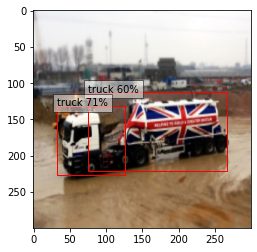

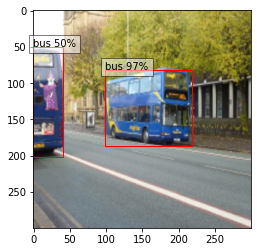

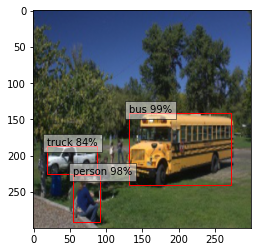

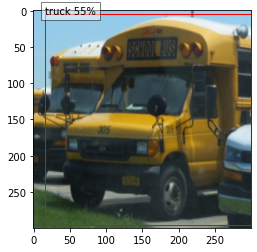

In [16]:
# get coco labels 
classesToLabels = utils.get_coco_object_dictionary()

# loop over the image batch
for image_idx in range(len(bestResults)):
	(fig, ax) = plt.subplots(1)
 
	# denormalize the image and plot the image
	image = processedInput[image_idx] / 2 + 0.5
	ax.imshow(image)
 
	# grab bbox, class, and confidence values
	(bboxes, classes, confidences) = bestResults[image_idx]

  # loop over the detected bounding boxes
	for idx in range(len(bboxes)):
		# scale values up according to image size
		(left, bot, right, top) = bboxes[idx ] * 300
    
		# draw the bounding box on the image
		(x, y, w, h) = [val for val in [left, bot, right - left,
			top - bot]]
		rect = patches.Rectangle((x, y), w, h, linewidth=1,
			edgecolor="r", facecolor="none")
		ax.add_patch(rect)
		ax.text(x, y,
			"{} {:.0f}%".format(classesToLabels[classes[idx] - 1],
			confidences[idx] * 100),
			bbox=dict(facecolor="white", alpha=0.5))

In [17]:
# check to see if the output directory already exists, if not
# make the output directory
if not os.path.exists(SSD_OUTPUT):
    os.makedirs(SSD_OUTPUT)

# save plots to output directory
print("[INFO] saving the inference...")
outputFileName = os.path.join(SSD_OUTPUT, "output.png")
plt.savefig(outputFileName)

[INFO] saving the inference...


<Figure size 432x288 with 0 Axes>